In [1]:
# Cella 1 (Revisionata): Setup del Progetto, Librerie e Riproducibilità

# ------------------------------------------
# Gestione File e Sistema Operativo
# ------------------------------------------
import os
import zipfile
import random

# ------------------------------------------
# Manipolazione Dati e Calcolo Numerico
# ------------------------------------------
import numpy as np
import pandas as pd

# ------------------------------------------
# Audio Processing
# ------------------------------------------
import librosa
import librosa.display

# ------------------------------------------
# Visualizzazione
# ------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------
# Machine Learning e Deep Learning
# ------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    PReLU,
    MaxPooling2D,
    Conv2DTranspose,
    Add,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# ------------------------------------------
# Impostazione per la Riproducibilità
# ------------------------------------------
# Impostare un seed garantisce che gli esperimenti siano riproducibili.
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Seed per la riproducibilità impostato a: {SEED}")


# ------------------------------------------
# Stile Grafici e Verifica GPU
# ------------------------------------------
plt.style.use('seaborn-v0_8-darkgrid')
print("\nTensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("GPU sarà usata per l'addestramento.")
else:
    print("ATTENZIONE: Nessuna GPU trovata. L'addestramento sarà estremamente lento.")

Seed per la riproducibilità impostato a: 42

TensorFlow Version: 2.18.0
Num GPUs Available:  1
GPU sarà usata per l'addestramento.


In [2]:
# Cella 2 (Invariata): Download e Estrazione del Dataset GTZAN

# ------------------------------------------
# Configurazione dell'API di Kaggle
# ------------------------------------------
# Installiamo la libreria di Kaggle in modalità "silenziosa" (-q)
!pip install -q kaggle
# Creiamo la directory necessaria per il file di configurazione
!mkdir -p ~/.kaggle

from google.colab import files
print("Per favore, carica il tuo file 'kaggle.json'...")
# L'upload si bloccherà se il file è già presente nella sessione corrente.
# Se hai problemi, puoi cancellare il file dal pannello a sinistra e riprovare.
try:
    files.upload()
except Exception as e:
    print(f"Potrebbe essere già presente un file 'kaggle.json'. Errore: {e}")


# Copiamo il file JSON e impostiamo i permessi corretti
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nConfigurazione Kaggle completata.")

# ------------------------------------------
# Download ed Estrazione del Dataset
# ------------------------------------------
DATASET_PATH = "dataset"
DATASET_ZIP_PATH = "gtzan-dataset-music-genre-classification.zip"

if not os.path.exists(DATASET_PATH):
    print("\nDownload del dataset GTZAN in corso...")
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

    print("\nEstrazione del dataset in corso...")
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)
    # Rimuoviamo il file .zip per liberare spazio
    os.remove(DATASET_ZIP_PATH)
    print("Download ed Estrazione completati.")
else:
    print(f"\nLa directory '{DATASET_PATH}' esiste già. Salto il download e l'estrazione.")

# ------------------------------------------
# Verifica del contenuto e pulizia
# ------------------------------------------
GENRES_PATH = os.path.join(DATASET_PATH, 'Data', 'genres_original')

# Rimuoviamo un file noto per essere corrotto nel dataset GTZAN
corrupted_file_path = os.path.join(GENRES_PATH, 'jazz', 'jazz.00054.wav')
if os.path.exists(corrupted_file_path):
    os.remove(corrupted_file_path)
    print(f"Rimosso file corrotto: {corrupted_file_path}")

print(f"\nGeneri musicali trovati in '{GENRES_PATH}':")
# Controlliamo che le directory dei generi esistano e le elenchiamo
if os.path.exists(GENRES_PATH):
    genres = sorted([d for d in os.listdir(GENRES_PATH) if os.path.isdir(os.path.join(GENRES_PATH, d))])
    print(genres)
else:
    print(f"ERRORE: La directory dei generi '{GENRES_PATH}' non è stata trovata. Controlla il processo di estrazione.")

Per favore, carica il tuo file 'kaggle.json'...


Saving kaggle.json to kaggle (3).json

Configurazione Kaggle completata.

La directory 'dataset' esiste già. Salto il download e l'estrazione.

Generi musicali trovati in 'dataset/Data/genres_original':
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
# Cella 3 (Versione 256x256): Preprocessing per immagini di medie dimensioni

import tensorflow as tf
from tqdm import tqdm
import numpy as np
import librosa
import os

# ------------------------------------------
# Nuove Costanti per Preprocessing a 256x256
# ------------------------------------------
NPZ_PATH_CHUNKS_256 = "spectrograms_256_chunks.npz"
IMG_SIZE_256 = 256 # Nuova dimensione target

# Parametri audio (invariati)
SAMPLE_RATE = 22050
DURATION_FULL = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION_FULL
NUM_CHUNKS = 10
SAMPLES_PER_CHUNK = int(SAMPLES_PER_TRACK / NUM_CHUNKS)
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

# Percorso dei generi (definito nella Cella 2)
GENRES_PATH = os.path.join("dataset", 'Data', 'genres_original')

# ------------------------------------------
# Nuova Funzione di Preprocessing per 256x256
# ------------------------------------------
def create_chunked_spectrograms_256(data_path, npz_path):
    """
    Crea spettrogrammi ridimensionati a 256x256 e li salva in un file .npz.
    """
    if os.path.exists(npz_path):
        print(f"File '{npz_path}' trovato. Salto il preprocessing.")
        return

    print(f"Inizio preprocessing per immagini 256x256 con chunking...")

    data = {"images": [], "labels": []}
    all_genres = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

    for genre_idx, genre_label in enumerate(tqdm(all_genres, desc="Generi")):
        genre_path = os.path.join(data_path, genre_label)
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    for c in range(NUM_CHUNKS):
                        start_sample = SAMPLES_PER_CHUNK * c
                        end_sample = start_sample + SAMPLES_PER_CHUNK

                        if end_sample <= len(signal):
                            chunk_signal = signal[start_sample:end_sample]

                            mel_spec = librosa.feature.melspectrogram(
                                y=chunk_signal, sr=sr, n_fft=N_FFT,
                                hop_length=HOP_LENGTH, n_mels=N_MELS
                            )
                            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
                            img = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())

                            img_gray = img[..., np.newaxis]
                            # --- MODIFICA CHIAVE: Ridimensioniamo a 256x256 ---
                            resized_spec = tf.image.resize(img_gray, [IMG_SIZE_256, IMG_SIZE_256])
                            img_rgb = tf.image.grayscale_to_rgb(resized_spec)

                            data["images"].append((img_rgb.numpy() * 255).astype(np.uint8))
                            data["labels"].append(genre_idx)
                except Exception as e:
                    print(f"\nErrore durante l'elaborazione di {file_path}: {e}")

    print("\nSalvataggio del file .npz in corso...")
    # Questo array sarà grande, quindi ci vorrà un po' per crearlo e salvarlo.
    X_array = np.array(data["images"])
    print(f"Shape dell'array di immagini creato: {X_array.shape}")

    np.savez_compressed(
        npz_path,
        X=X_array,
        y=np.array(data["labels"]),
        mappings=all_genres
    )
    print(f"\nDati salvati in '{npz_path}'.")

# Eseguiamo la nuova funzione di preprocessing
create_chunked_spectrograms_256(GENRES_PATH, NPZ_PATH_CHUNKS_256)

File 'spectrograms_256_chunks.npz' trovato. Salto il preprocessing.


In [4]:
# Cella 3.1: Conversione dei Dati in Formato TFRecord per un Addestramento Veloce

import tensorflow as tf
import numpy as np
import os
import gc
from tqdm import tqdm
from sklearn.model_selection import train_test_split

print("--- Fase 1: Setup Indici e Percorsi ---")

# Definiamo i percorsi
NPZ_PATH_CHUNKS_256 = "spectrograms_256_chunks.npz"
TFRECORD_TRAIN_PATH = "train_256.tfrecord"
TFRECORD_TEST_PATH = "test_256.tfrecord"
SEED = 42

# Funzioni helper per la serializzazione in TFRecord
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, label):
    feature = {
        'image': _bytes_feature(tf.io.serialize_tensor(image)),
        'label_index': _int64_feature(label), # Salviamo l'indice della classe, non il one-hot
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Controlla se i file TFRecord esistono già
if os.path.exists(TFRECORD_TRAIN_PATH) and os.path.exists(TFRECORD_TEST_PATH):
    print("File TFRecord già esistenti. Salto la creazione.")
    # Carichiamo solo il numero di campioni se i file esistono già
    with np.load(NPZ_PATH_CHUNKS_256, allow_pickle=True) as data:
        y_full = data['y']
        mappings = data['mappings']
    indices = np.arange(len(y_full))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=y_full)
    NUM_CLASSES = len(mappings)

else:
    print("\n--- Fase 2: Conversione in TFRecord ---")
    print(f"Caricamento dati da '{NPZ_PATH_CHUNKS_256}' per la conversione...")
    with np.load(NPZ_PATH_CHUNKS_256, allow_pickle=True) as data:
        X_full = data['X']
        y_full = data['y']
        mappings = data['mappings']
        NUM_CLASSES = len(mappings)

    indices = np.arange(len(y_full))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=y_full)

    # Scrittura del file di training
    print(f"Creazione del file TFRecord di training: {TFRECORD_TRAIN_PATH}")
    with tf.io.TFRecordWriter(TFRECORD_TRAIN_PATH) as writer:
        for i in tqdm(train_indices, desc="Scrittura dati di training"):
            example = serialize_example(X_full[i].astype(np.uint8), y_full[i])
            writer.write(example)

    # Scrittura del file di test
    print(f"Creazione del file TFRecord di test: {TFRECORD_TEST_PATH}")
    with tf.io.TFRecordWriter(TFRECORD_TEST_PATH) as writer:
        for i in tqdm(test_indices, desc="Scrittura dati di test"):
            example = serialize_example(X_full[i].astype(np.uint8), y_full[i])
            writer.write(example)

    del X_full, y_full
    gc.collect()
    print("\nConversione in TFRecord completata.")

--- Fase 1: Setup Indici e Percorsi ---
File TFRecord già esistenti. Salto la creazione.


In [5]:
# Cella 4: Costruzione del Modello (Invariata)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, PReLU, MaxPooling2D, Conv2DTranspose, Add, GlobalAveragePooling2D, Dense, Dropout

# Definisci la funzione del modello (uguale a prima)
def build_paper_model_256(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(16, (3, 3), padding='same')(inputs); prelu1 = PReLU(shared_axes=[1, 2])(conv1); pool1 = MaxPooling2D(pool_size=(2, 2))(prelu1)
    conv2 = Conv2D(32, (3, 3), padding='same')(pool1); prelu2 = PReLU(shared_axes=[1, 2])(conv2); pool2 = MaxPooling2D(pool_size=(2, 2))(prelu2)
    conv3 = Conv2D(64, (3, 3), padding='same')(pool2); prelu3 = PReLU(shared_axes=[1, 2])(conv3); pool3 = MaxPooling2D(pool_size=(2, 2))(prelu3)
    conv4 = Conv2D(128, (3, 3), padding='same')(pool3); prelu4 = PReLU(shared_axes=[1, 2])(conv4); pool4 = MaxPooling2D(pool_size=(2, 2))(prelu4)
    conv_neck = Conv2D(256, (3, 3), padding='same')(pool4); prelu_neck = PReLU(shared_axes=[1, 2])(conv_neck)
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(prelu_neck); skip4 = Add()([up4, prelu4]); conv4_dec = Conv2D(128, (3, 3), padding='same')(skip4); prelu4_dec = PReLU(shared_axes=[1, 2])(conv4_dec)
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(prelu4_dec); skip3 = Add()([up3, prelu3]); conv3_dec = Conv2D(64, (3, 3), padding='same')(skip3); prelu3_dec = PReLU(shared_axes=[1, 2])(conv3_dec)
    up2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(prelu3_dec); skip2 = Add()([up2, prelu2]); conv2_dec = Conv2D(32, (3, 3), padding='same')(skip2); prelu2_dec = PReLU(shared_axes=[1, 2])(conv2_dec)
    up1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(prelu2_dec); skip1 = Add()([up1, prelu1]); conv1_dec = Conv2D(16, (3, 3), padding='same')(skip1); unet_output = PReLU(shared_axes=[1, 2])(conv1_dec)
    gap = GlobalAveragePooling2D()(unet_output); dropout = Dropout(0.5)(gap); outputs = Dense(num_classes, activation='softmax', dtype='float32')(dropout) # dtype='float32' per la precisione mista
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Costruisci e compila
IMG_SIZE_256 = 256
INPUT_SHAPE_256 = (IMG_SIZE_256, IMG_SIZE_256, 3)

model_256 = build_paper_model_256(INPUT_SHAPE_256, NUM_CLASSES)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_256.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_256.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 256, 256,  │         16 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 128, 128,  │         32 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ p_re_lu_1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 64, 64,    │         64 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ p_re_lu_2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ p_re_lu_3[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ p_re_lu_4[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 763,914 (2.91 MB)

 Trainable params: 763,914 (2.91 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cella 5 (Finale e Corretta - Addestramento Veloce con TFRecord)

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np # Necessario per len() su train_indices

# ------------------------------------------
# 1. Pipeline di Dati da TFRecord (con .repeat())
# ------------------------------------------
BATCH_SIZE = 32
# Attiva la precisione mista per velocità e minor uso di VRAM
keras.mixed_precision.set_global_policy('mixed_float16')

# Percorsi e variabili globali necessarie
TFRECORD_TRAIN_PATH = "train_256.tfrecord"
TFRECORD_TEST_PATH = "test_256.tfrecord"
# train_indices e test_indices sono stati creati nella Cella 3.1
# NUM_CLASSES è stato definito nella Cella 3.1
# IMG_SIZE_256 è stato definito nella Cella 4

# Funzione per parsare i dati dal formato TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label_index': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)

    # Deserializza l'immagine e normalizzala
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, (IMG_SIZE_256, IMG_SIZE_256, 3))
    image = tf.cast(image, tf.float32) / 255.0

    # Converte l'etichetta in one-hot
    label = tf.one_hot(example['label_index'], depth=NUM_CLASSES)

    return image, label

# Creazione dei dataset
# L'aggiunta di .repeat() elimina il warning e crea una pipeline dati robusta.
train_dataset = (
    tf.data.TFRecordDataset(TFRECORD_TRAIN_PATH)
    .map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=1024) # buffer_size consiglia di essere > batch_size
    .batch(BATCH_SIZE)
    .repeat() # Il dataset ora può essere iterato all'infinito
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Pre-caricamento per efficienza
)

test_dataset = (
    tf.data.TFRecordDataset(TFRECORD_TEST_PATH)
    .map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .repeat() # Aggiunto anche qui per coerenza
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# ------------------------------------------
# 2. Addestramento
# ------------------------------------------
EPOCHS = 50
MODEL_CHECKPOINT_PATH_256 = "best_paper_model_256.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT_PATH_256, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=1e-6)
]

print("\n--- Avvio Addestramento del Modello 256x256 con TFRecord (Versione Corretta e Veloce) ---")

# Quando si usa .repeat(), è OBBLIGATORIO specificare steps_per_epoch e validation_steps
# per dire a Keras quanti batch costituiscono un'epoca.
history_256 = model_256.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_indices) // BATCH_SIZE,
    validation_steps=len(test_indices) // BATCH_SIZE,
    callbacks=callbacks
)

print("\n--- Addestramento Completato ---")

history_df_256 = pd.DataFrame(history_256.history)
history_df_256.to_csv('training_history_paper_model_256.csv', index=False)
print("\nCronologia dell'addestramento salvata.")


--- Avvio Addestramento del Modello 256x256 con TFRecord (Versione Corretta e Veloce) ---
Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.1084 - loss: 2.2968
Epoch 1: val_accuracy improved from -inf to 0.18196, saving model to best_paper_model_256.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 75s 261ms/step - accuracy: 0.1085 - loss: 2.2967 - val_accuracy: 0.1820 - val_loss: 2.1848 - learning_rate: 0.0010
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.1740 - loss: 2.1717
Epoch 2: val_accuracy improved from 0.18196 to 0.18599, saving model to best_paper_model_256.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.1740 - loss: 2.1716 - val_accuracy: 0.1860 - val_loss: 2.0607 - learning_rate: 0.0010
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.1979 - loss: 2.0702
Epoch 3: val_accuracy improved from 0.18599 to 0.21421, saving model to best_paper_model_256.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.1980 

Caricamento del miglior modello da 'best_paper_model_256.keras'...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 80 variables whereas the saved optimizer has 76 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 76 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Modello caricato.


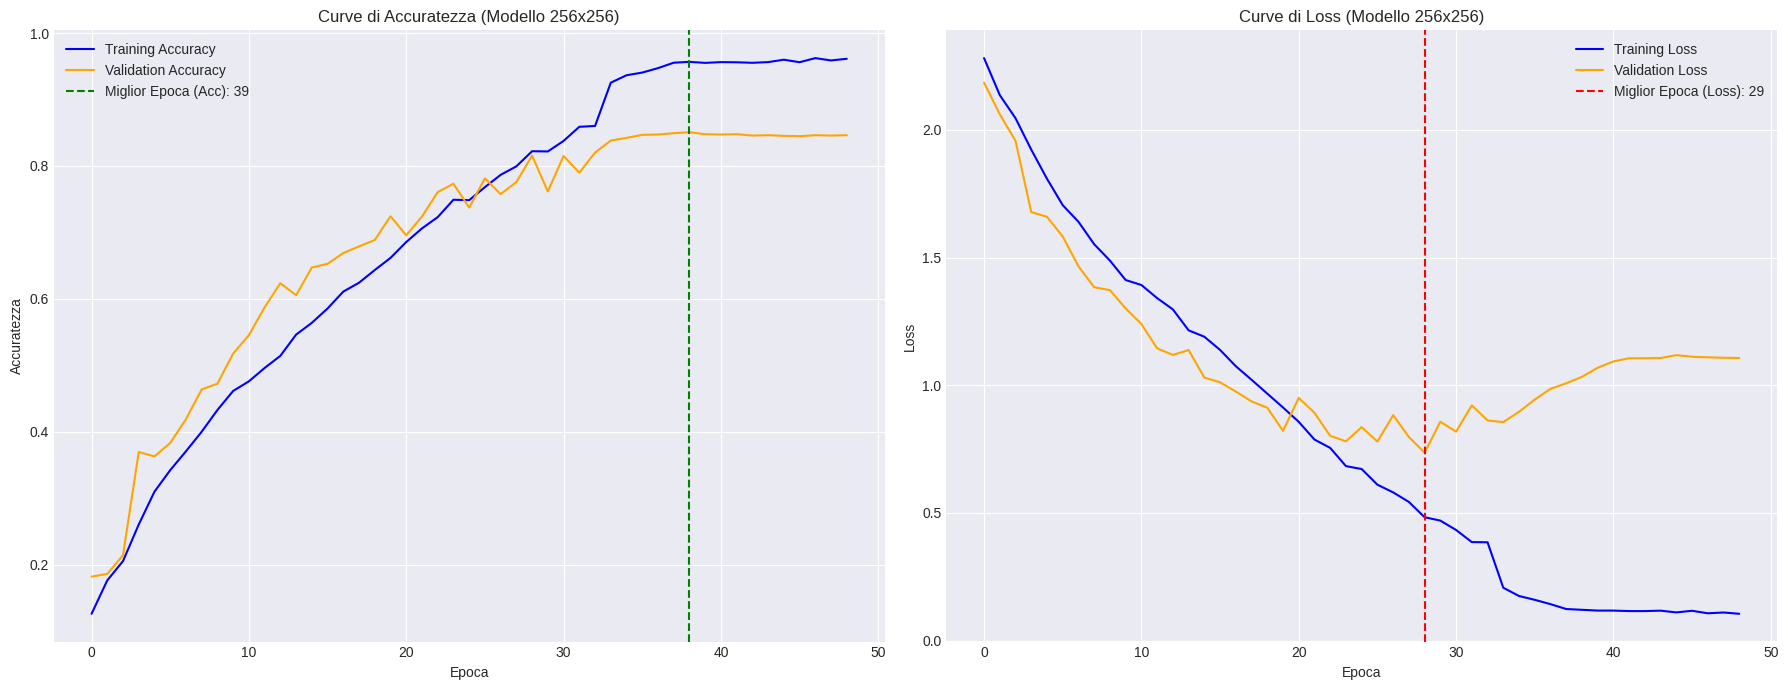


--- Valutazione Finale sul Test Set (Modello 256x256) ---
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8566 - loss: 0.9544
Accuratezza sul Test Set: 85.08%
Loss sul Test Set: 1.0327

Ottenimento delle predizioni dal test set...


Predizioni: 63it [00:10,  6.15it/s]



--- Matrice di Confusione (Modello 256x256) ---


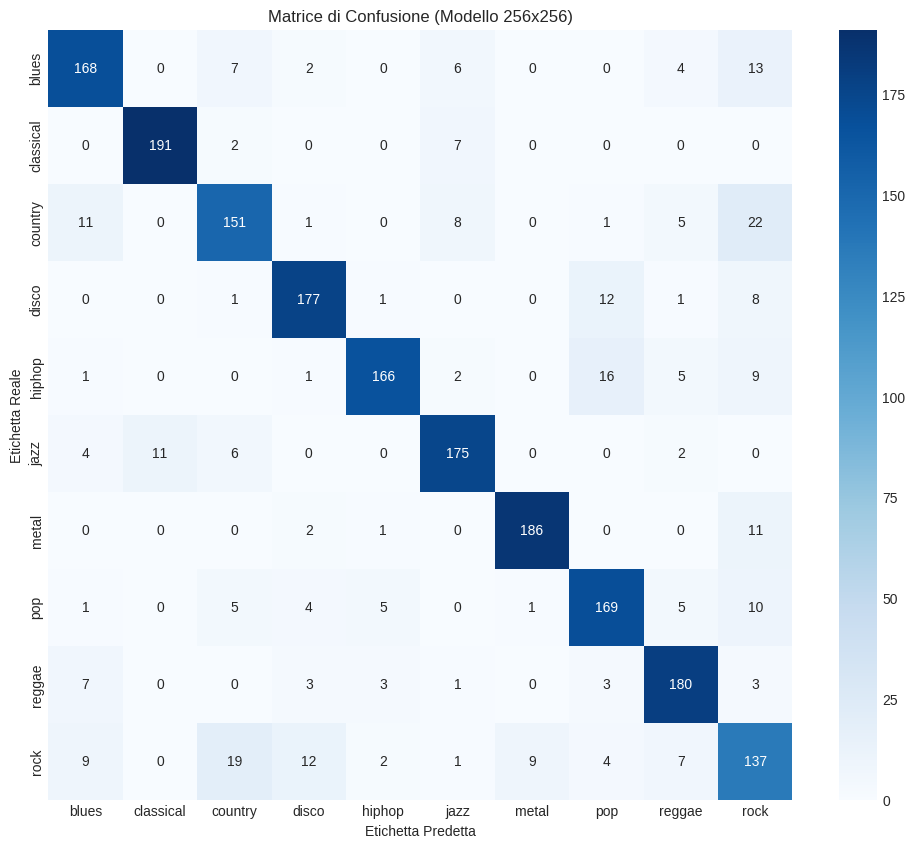


--- Classification Report (Modello 256x256) ---
              precision    recall  f1-score   support

       blues      0.836     0.840     0.838       200
   classical      0.946     0.955     0.950       200
     country      0.791     0.759     0.774       199
       disco      0.876     0.885     0.881       200
      hiphop      0.933     0.830     0.878       200
        jazz      0.875     0.884     0.879       198
       metal      0.949     0.930     0.939       200
         pop      0.824     0.845     0.835       200
      reggae      0.861     0.900     0.880       200
        rock      0.643     0.685     0.663       200

    accuracy                          0.851      1997
   macro avg      0.853     0.851     0.852      1997
weighted avg      0.853     0.851     0.852      1997



In [8]:
# Cella 6 (Versione 256x256 - Corretta e Completa): Analisi dei Risultati

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# ------------------------------------------
# 1. Caricamento del Miglior Modello Salvato
# ------------------------------------------
MODEL_CHECKPOINT_PATH_256 = "best_paper_model_256.keras"
HISTORY_CSV_PATH_256 = 'training_history_paper_model_256.csv'

print(f"Caricamento del miglior modello da '{MODEL_CHECKPOINT_PATH_256}'...")
best_model_256 = keras.models.load_model(MODEL_CHECKPOINT_PATH_256)
print("Modello caricato.")

# ------------------------------------------
# 2. Visualizzazione delle Curve di Apprendimento (con linea per la loss)
# ------------------------------------------
history_df_256 = pd.read_csv(HISTORY_CSV_PATH_256)

plt.figure(figsize=(18, 7))

# Grafico dell'Accuratezza
plt.subplot(1, 2, 1)
plt.plot(history_df_256['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_df_256['val_accuracy'], label='Validation Accuracy', color='orange')
best_epoch_acc = history_df_256['val_accuracy'].idxmax()
plt.axvline(best_epoch_acc, color='g', linestyle='--', label=f'Miglior Epoca (Acc): {best_epoch_acc + 1}')
plt.title('Curve di Accuratezza (Modello 256x256)')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')
plt.legend()
plt.grid(True)

# Grafico della Loss
plt.subplot(1, 2, 2)
plt.plot(history_df_256['loss'], label='Training Loss', color='blue')
plt.plot(history_df_256['val_loss'], label='Validation Loss', color='orange')
# --- CORREZIONE: Aggiungo la linea verticale per la loss minima ---
best_epoch_loss = history_df_256['val_loss'].idxmin()
plt.axvline(best_epoch_loss, color='r', linestyle='--', label=f'Miglior Epoca (Loss): {best_epoch_loss + 1}')
plt.title('Curve di Loss (Modello 256x256)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ------------------------------------------
# 3. Valutazione Finale sul Test Set
# ------------------------------------------
print("\n--- Valutazione Finale sul Test Set (Modello 256x256) ---")
# Assicurati che BATCH_SIZE sia definito, se stai eseguendo questa cella separatamente
try:
    BATCH_SIZE
except NameError:
    BATCH_SIZE = 32 # Valore di default

loss, accuracy = best_model_256.evaluate(test_dataset, steps=len(test_indices) // BATCH_SIZE, verbose=1)
print(f"Accuratezza sul Test Set: {accuracy * 100:.2f}%")
print(f"Loss sul Test Set: {loss:.4f}")

# ------------------------------------------
# 4. Matrice di Confusione e Classification Report
# ------------------------------------------
print("\nOttenimento delle predizioni dal test set...")
y_true_list = []
y_pred_list = []

# Usiamo take() per iterare solo una volta sul dataset di test
# È importante non usare .repeat() sul test set durante la valutazione finale
test_dataset_for_eval = (
    tf.data.TFRecordDataset(TFRECORD_TEST_PATH)
    .map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

for images, labels in tqdm(test_dataset_for_eval, desc="Predizioni"):
    preds = best_model_256.predict_on_batch(images)
    y_true_list.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_list.extend(np.argmax(preds, axis=1))

y_true_labels = np.array(y_true_list)
y_pred_labels = np.array(y_pred_list)

print("\n--- Matrice di Confusione (Modello 256x256) ---")
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=mappings, yticklabels=mappings)
plt.title('Matrice di Confusione (Modello 256x256)')
plt.xlabel('Etichetta Predetta')
plt.ylabel('Etichetta Reale')
plt.show()

print("\n--- Classification Report (Modello 256x256) ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=mappings, digits=3))